# 광주은행 KJ7
#### 데이터분석부(개인신용대출분석팀) 최대훈 대리
#### 수도권전략부 이건호 대리
##### 목표 : 과거 구매 이력과 현재 구매 정보를 활용하여, 과거 구매 상품 중 현재 재구매 할 만한 상품을 제안 (예측)

In [143]:
from jbfg.pandas_utils import *
from impala.dbapi import connect
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
# pd.set_option('display.max_columns',None)  # 칼럼 전체 표시

# pd.set_option('display.max_rows',None)      # row 전체 표시

In [103]:
path_input = "./"
path_input_rifined = path_input + "refined/"
path_code = './'
path_output = "./"

In [104]:
def _connect_impala():
    return connect(host   = 'impala.dhap.jbfg.com',
                   port   = 21050,
                   database = 'l2_kjbk_extnl',
                   auth_mechanism = 'GSSAPI',
                   kerberos_service_name = 'impala'
                  )

In [105]:
# 광주은행 데이터셋
schema = 'l2_kjbk_extnl'

In [106]:
# 100개 상품정보
# sql1 = 'SELECT * FROM products_info'

In [107]:
# df_products_info = get_df(sql1, schema)

In [108]:
# df_products_info.tail()

In [109]:
def _copy_to_pickle(tablename):
    sql = f"""
    SELECT *
    FROM   {tablename}
    """
    con = _connect_impala()
    df = pd.read_sql(sql,con)
    con.close()
    file = open(f"{path_input}{tablename}.pickle","wb")
    df.to_pickle(file)
    file.close()
    print(f"{tablename} was copied into pickle")
    return df

# 문자형 숫자값 정수형 변환

In [110]:
def _str2int(strV,replaceV_when_blank):
    if strV in (None, " ",""): return int(replaceV_when_blank)
    else: return int(float(strV.replace(" ","")))

In [111]:
def _len(l):
    if type(l) != list: return 0
    else: return len(l)

## 파일 load

In [112]:
def _load_from_pickle(file,cols=None):
    file = open(path_input+file,"rb")
    if cols == None:
        df = pickle.load(file)
    else:
        df = pickle.load(file)[cols]
    file.close()
    return df

In [113]:
def _dump_to_pickle(df,file,cols=None):
    file = open(path_input+file, "wb")
    if cols == None:
        pickle.dump(df,file)
    else:
        pickle.dump(df[cols],file)
    file.close()

# 데이터 불러오기

In [114]:
%%time
for tablename in ("products_info","train_x_past","train_x_current","train_y","test_x_past","test_x_current"):
    _copy_to_pickle(tablename)

products_info was copied into pickle
train_x_past was copied into pickle
train_x_current was copied into pickle
train_y was copied into pickle
test_x_past was copied into pickle
test_x_current was copied into pickle
CPU times: user 10.4 s, sys: 1.41 s, total: 11.8 s
Wall time: 15.6 s


# 데이터 탐색

In [115]:
%%time
train_x_past = _load_from_pickle('train_x_past.pickle')

CPU times: user 557 ms, sys: 349 ms, total: 906 ms
Wall time: 909 ms


In [116]:
train_x_past.dtypes

order_id          object
cstno             object
order_number      object
week_day          object
order_hour        object
order_interval    object
add_order         object
is_reordered      object
product_id        object
dtype: object

In [117]:
# 문자형이면 작업이 어려우므로 정수형 변환
train_x_past.order_number  = train_x_past.order_number.astype(int)
train_x_past.week_day      = train_x_past.week_day.astype(int)
train_x_past.order_hour    = train_x_past.order_hour.astype(int)
train_x_past.order_interval= train_x_past.order_interval.map(lambda x : _str2int(x,0))
train_x_past.add_order     = train_x_past.add_order.astype(int)
train_x_past.is_reordered  = train_x_past.is_reordered.astype(int)

In [118]:
train_x_past.dtypes

order_id          object
cstno             object
order_number       int64
week_day           int64
order_hour         int64
order_interval     int64
add_order          int64
is_reordered       int64
product_id        object
dtype: object

In [119]:
train_x_past.head(5)

order_id   cstno  order_number  week_day  order_hour  order_interval  \
0   717029  196613            15         1           9               3   
1  2325772  196613            35         6          11               2   
2   642668  196613            69         2          16               2   
3  1326515  196613            61         3          19               3   
4  1437845  196613            36         3          15               4   

   add_order  is_reordered product_id  
0          5             0      41220  
1          7             1      41220  
2         11             1       4210  
3          3             1       4210  
4         16             0       4210

In [120]:
%%time
cols = ["order_id", "cstno", "order_number", "week_day", "order_hour", "order_interval"]
orders = train_x_past[cols].drop_duplicates()
orders.sort_values(["cstno","order_number"],inplace=True)

CPU times: user 384 ms, sys: 112 ms, total: 496 ms
Wall time: 496 ms


In [121]:
orders.head(10)

order_id  cstno  order_number  week_day  order_hour  order_interval
423306  1492646  10000             1         0          11               0
423288  1444722  10000             2         6           7               6
423308  3272690  10000             3         1          11               2
423309  2152976  10000             4         4          13               3
423336   859342  10000             5         4          21               0
423272   103998  10000             6         3           6               6
423295  3146859  10000             7         5          12               2
423301  2306339  10000             8         0          10               9
423355  1765454  10000             9         5          15               5
423274   377814  10000            10         1           6               3

In [122]:
%%time
r=orders.groupby('cstno').order_id.count()

CPU times: user 63.8 ms, sys: 3.87 ms, total: 67.6 ms
Wall time: 67.3 ms


In [123]:
r.describe()

count    5859.000000
mean       58.316778
std        14.640439
min        42.000000
25%        47.000000
50%        53.000000
75%        66.000000
max        99.000000
Name: order_id, dtype: float64

In [124]:
# 1명당 평균 58번의 주문
# min: 42 max : 99

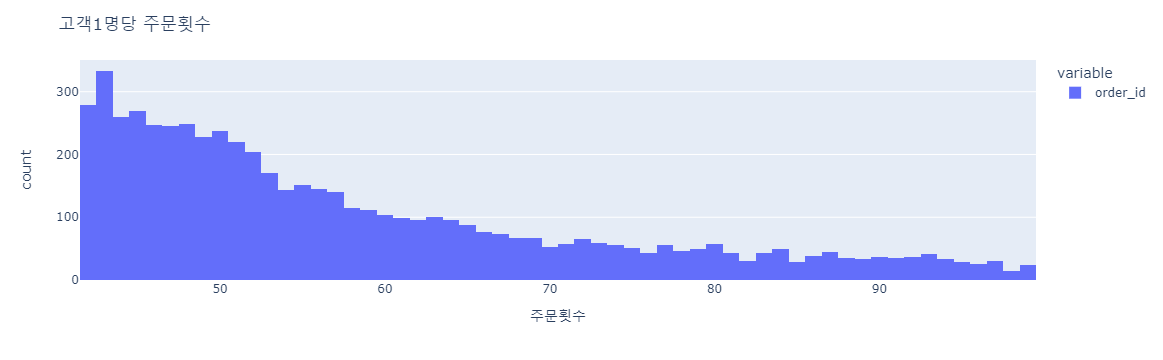

In [125]:
fig = px.histogram(r).update_layout(title = '고객1명당 주문횟수', xaxis_title = '주문횟수')
fig.show()

# 1인당 몇개까지?

In [126]:
%%time
cols = ["order_id", "cstno", "order_number", "week_day", "order_hour", "order_interval","product_id"]
tops = train_x_past[cols].drop_duplicates()
tops.sort_values(["cstno","order_number"],inplace=True)

CPU times: user 637 ms, sys: 118 ms, total: 755 ms
Wall time: 755 ms


In [127]:
tops.head(10)

order_id  cstno  order_number  week_day  order_hour  order_interval  \
423306  1492646  10000             1         0          11               0   
423390  1492646  10000             1         0          11               0   
423418  1492646  10000             1         0          11               0   
423454  1492646  10000             1         0          11               0   
423501  1492646  10000             1         0          11               0   
423511  1492646  10000             1         0          11               0   
423527  1492646  10000             1         0          11               0   
423552  1492646  10000             1         0          11               0   
423597  1492646  10000             1         0          11               0   
423288  1444722  10000             2         6           7               6   

       product_id  
423306      15290  
423390       5077  
423418      26604  
423454      27104  
423501      22935  
423511      47766  
423527      21903  
423552      21137  
423597      24852  
423288       4799

In [128]:
%%time
r2=tops.groupby('order_id').order_number.count()

CPU times: user 670 ms, sys: 34 ms, total: 704 ms
Wall time: 704 ms


In [129]:
r2.describe()

count    341678.000000
mean          3.670040
std           2.548844
min           1.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          26.000000
Name: order_number, dtype: float64

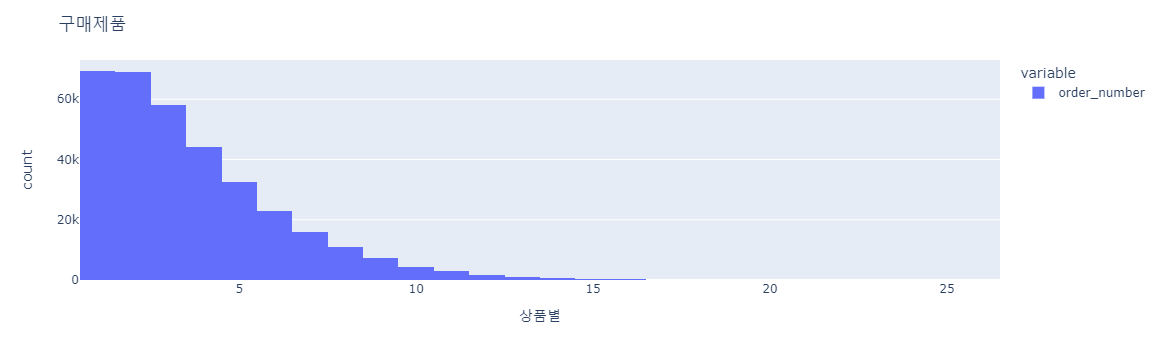

In [130]:
fig = px.histogram(r2).update_layout(title = '구매제품', xaxis_title = '상품별')
fig.show()

# 고객별로 가장 많이 구매한 제품 리스트를 찾아보자

In [131]:
sql = """
               select
                       a.product_id    AS 상품id,
                       b.name          AS 상품명,
                       b.category_name AS 분류,
                       count(a.product_id) AS 구매횟수
               from train_x_past a LEFT JOIN products_info b             -- 과거 구매이력에 상품명 붙이기위함
                                   ON a.product_id = b.product_id
               group by a.product_id, b.name, b.category_name
               order by 구매횟수 desc
               
      """
df_train_x_past = get_df(sql, schema)

In [132]:
df_train_x_past.head(5)

상품id                     상품명                          분류   구매횟수
0  24852                  Banana                fresh fruits  74686
1  13176  Bag of Organic Bananas                fresh fruits  67514
2  21137    Organic Strawberries                fresh fruits  52917
3  47209    Organic Hass Avocado                fresh fruits  42604
4  21903    Organic Baby Spinach  packaged vegetables fruits  40112

In [133]:
sql2 = """
               select
                       a.cstno         AS 고객번호,
                       a.product_id    AS 상품id,
                       b.name          AS 상품명,
                       b.category_name AS 분류,
                       count(a.product_id) AS 구매횟수
               from train_x_past a LEFT JOIN products_info b             -- 과거 구매이력에 상품명 붙이기위함
                                   ON a.product_id = b.product_id
               where a.cstno = '10000'                                   -- 고객번호 입력
               group by a.cstno, a.product_id, b.name, b.category_name
               order by 구매횟수 desc
               
      """
df_train_x_past_cst = get_df(sql2, schema)
df_train_x_past_cst.head()

고객번호   상품id                     상품명                분류  구매횟수
0  10000  21137    Organic Strawberries      fresh fruits    44
1  10000   5077  100% Whole Wheat Bread             bread    41
2  10000  24852                  Banana      fresh fruits    30
3  10000  49235     Organic Half & Half             cream    21
4  10000  28985   Michigan Organic Kale  fresh vegetables    17

In [134]:
    sql3 = """
               select
                       a.order_number  AS 주문순서,
                       a.product_id    AS 상품id,
                       b.name          AS 상품명,
                       b.category_name AS 분류,
                       count(a.product_id) AS 구매횟수
               from train_x_past a LEFT JOIN products_info b             -- 과거 구매이력에 상품명 붙이기위함
                                   ON a.product_id = b.product_id
               where a.order_number = '1'                                -- 주문번호
               group by a.order_number, a.product_id, b.name, b.category_name
               order by 구매횟수 desc
               
            """
df_train_x_past_order = get_df(sql3, schema)
df_train_x_past_order.tail(10)

주문순서   상품id                                             상품명  \
90    1  12341                                   Hass Avocados   
91    1  34358                                          Garlic   
92    1  43352                                     Raspberries   
93    1  47144  Unsweetened Original Almond Breeze Almond Milk   
94    1  11520                             Large Alfresco Eggs   
95    1  21709                           Sparkling Lemon Water   
96    1  29487                                     Roma Tomato   
97    1  23909                             2% Reduced Fat Milk   
98    1   5450                              Small Hass Avocado   
99    1    196                                            Soda   

                               분류  구매횟수  
90               packaged produce    79  
91               fresh vegetables    74  
92               packaged produce    72  
93                soy lactosefree    71  
94                           eggs    64  
95  water seltzer sparkling water    60  
96               fresh vegetables    60  
97                           milk    57  
98                   fresh fruits    54  
99                    soft drinks    39

In [146]:
train_x_past.head(5)

order_id   cstno  order_number  week_day  order_hour  order_interval  \
0   717029  196613            15         1           9               3   
1  2325772  196613            35         6          11               2   
2   642668  196613            69         2          16               2   
3  1326515  196613            61         3          19               3   
4  1437845  196613            36         3          15               4   

   add_order  is_reordered product_id  
0          5             0      41220  
1          7             1      41220  
2         11             1       4210  
3          3             1       4210  
4         16             0       4210

In [230]:
sql4 = """
               select
                       a.cstno,
                       a.product_id    AS 상품id,
                       b.name          AS 상품명,
                       b.category_name AS 분류,
                       count(a.order_number) AS 구매횟수
               from train_x_past a LEFT JOIN products_info b             -- 과거 구매이력에 상품명 붙이기위함
                                   ON a.product_id = b.product_id
               where a.cstno = '50'                                -- 주문번호
               group by a.cstno, a.product_id, b.name, b.category_name
               order by 구매횟수 desc
       """
df_train_x_past_max = get_df(sql4, schema)
df_train_x_past_max

cstno   상품id                                          상품명  \
0     50  41950                       Organic Tomato Cluster   
1     50  47209                         Organic Hass Avocado   
2     50  13176                       Bag of Organic Bananas   
3     50  45007                             Organic Zucchini   
4     50  22825                        Organic D'Anjou Pears   
5     50  39877                   Organic Granny Smith Apple   
6     50  21903                         Organic Baby Spinach   
7     50  22935                         Organic Yellow Onion   
8     50  34126                Organic Italian Parsley Bunch   
9     50   9839                             Organic Broccoli   
10    50  21137                         Organic Strawberries   
11    50   5876                                Organic Lemon   
12    50  46667                          Organic Ginger Root   
13    50  48679            Organic Garnet Sweet Potato (Yam)   
14    50   8518                            Organic Red Onion   
15    50  27104                            Fresh Cauliflower   
16    50  24964                               Organic Garlic   
17    50  16759                         Organic Carrot Bunch   
18    50  27521             Organic Lacinato (Dinosaur) Kale   
19    50   5785                  Organic Reduced Fat 2% Milk   
20    50  18465  Organic Grade A Free Range Large Brown Eggs   

                            분류  구매횟수  
0             fresh vegetables    19  
1                 fresh fruits    17  
2                 fresh fruits    17  
3             fresh vegetables    16  
4                 fresh fruits    11  
5                 fresh fruits    11  
6   packaged vegetables fruits     9  
7             fresh vegetables     8  
8                  fresh herbs     7  
9             fresh vegetables     4  
10                fresh fruits     4  
11                fresh fruits     3  
12            fresh vegetables     3  
13            fresh vegetables     3  
14            fresh vegetables     2  
15            fresh vegetables     2  
16            fresh vegetables     2  
17            fresh vegetables     2  
18            fresh vegetables     1  
19                        milk     1  
20                        eggs     1

In [260]:
r3 = train_x_past.groupby('cstno')['order_number'].max()

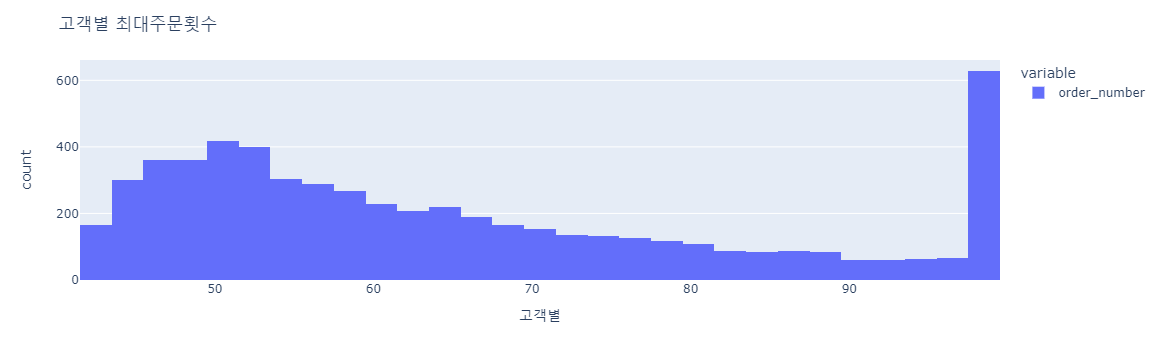

In [261]:
fig = px.histogram(r3).update_layout(title = '고객별 최대주문횟수', xaxis_title = '고객별')
fig.show()

In [246]:
sql5 = """
               select distinct
                a.cstno,
                to_number('a.order_number',2.0)
            
               from train_x_past a LEFT JOIN products_info b             -- 과거 구매이력에 상품명 붙이기위함
                                   ON a.product_id = b.product_id
               where a.cstno = '50'                                -- 주문번호
               order by a.order_number asc
       """
df_train_x_past_sort = get_df(sql5, schema)
df_train_x_past_sort.head(20)

DatabaseError: Execution failed on sql '
               select distinct
                a.cstno,
                to_number('a.order_number',2.0)
            
               from train_x_past a LEFT JOIN products_info b             -- 과거 구매이력에 상품명 붙이기위함
                                   ON a.product_id = b.product_id
               where a.cstno = '50'                                -- 주문번호
               order by a.order_number asc
       ': ('HY000', '[HY000] [Cloudera][ImpalaODBC] (110) Error while executing a query in Impala: [HY000] : AnalysisException: l2_kjbk_extnl.to_number() unknown for database l2_kjbk_extnl. Currently this db has 0 functions.\n (110) (SQLExecDirectW)')

## 1.상품별 구매횟수 많은 상품

## 2.최근 구매 상품(상품 선호도)

## 3.직전 구매 상품 재구매x --> 제거

#### => 3가지 조건 부합 = Final

In [121]:
# sql = 'SELECT DISTINCT product_id FROM products_info'
# df_products_info = get_df(sql, schema)
# df_products_info

In [178]:
# 5,859명 고객 과거 구매 이력
sql2 = "SELECT * FROM train_x_past  "
df_train_x_past = get_df(sql2, schema)

In [179]:
# df_train_x_past.head()
df_train_x_past.head()
# ROWS 1253972

order_id   cstno order_number week_day order_hour order_interval add_order  \
0   717029  196613           15        1          9            3.0         5   
1  2325772  196613           35        6         11            2.0         7   
2   642668  196613           69        2         16            2.0        11   
3  1326515  196613           61        3         19            3.0         3   
4  1437845  196613           36        3         15            4.0        16   

  is_reordered product_id  
0            0      41220  
1            1      41220  
2            1       4210  
3            1       4210  
4            0       4210

In [156]:
sql2 = """
         SELECT *
         FROM train_x_past
         where 1=1
        -- cstno IN ('196613', '32775', '32780','32805','163819')
         AND is_reordered = '1'
         AND add_order = '1'
        -- AND order_interval = '15.0'
       """
df_train_x_past2 = get_df(sql2, schema)
df_train_x_past2.tail()

order_id   cstno order_number week_day order_hour order_interval  \
119329  1218210  163819           13        1         11            6.0   
119330  1471330  163819            7        1         10           12.0   
119331  1714563  163819            3        1         16           13.0   
119332  2549215  163819            9        1         11            7.0   
119333  3207262  163819            8        1         12            7.0   

       add_order is_reordered product_id  
119329         1            1      24852  
119330         1            1      24852  
119331         1            1      24852  
119332         1            1      24852  
119333         1            1      24852

In [125]:
# # cstno 리스트
# sql = "SELECT distinct cstno FROM train_x_past"
# df_train_x_past = get_df(sql, schema)
# df_train_x_past

In [186]:
# 상품 ID를 제외한 5,859명 고객들의 현재 구매정보
sql3 = 'SELECT * FROM train_x_current'
df_train_x_current = get_df(sql3, schema)
df_train_x_current.head()

order_id   cstno order_number week_day order_hour order_interval add_order  \
0   806422   41116           47        5         18            3.0         4   
1  2146033  127113           45        1         10            7.0        24   
2  3055498  140168           45        5         10           26.0        11   
3  3267527   60604           52        0         16            8.0         2   
4  3125992  136554           46        4          9            5.0         2   

  is_reordered  
0            1  
1            1  
2            1  
3            1  
4            0

In [127]:
sql33 = "SELECT * FROM train_x_current where cstno = '196613'"
df_train_x_current3 = get_df(sql33, schema)
df_train_x_current3

order_id   cstno order_number week_day order_hour order_interval add_order  \
0  2414402  196613          100        6         13            5.0         4   
1  2414402  196613          100        6         13            5.0         1   

  is_reordered  
0            1  
1            1

In [128]:
df_train_x_current.tail()
# ROWS 24424

order_id   cstno order_number week_day order_hour order_interval  \
24419  3184000  174046          100        5          7            2.0   
24420  1754722    6710          100        5         11            3.0   
24421  1076973  150840          100        0         13            0.0   
24422  1247049   99707          100        1         13            3.0   
24423  1775787  201038          100        5          9            2.0   

      add_order is_reordered  
24419        12            1  
24420        21            1  
24421        18            1  
24422         6            1  
24423         1            1

In [78]:
# 5,859명 고객 현재 주문 정보에 대한 상품 ID
# sql4 = 'SELECT * FROM train_y'
# df_train_y = get_df(sql4, schema)
# df_train_y.iloc[20001:24424]
# # ROWS 24424

In [99]:
# 4,141명 고객들의 과거 구매 이력
sql5 = 'SELECT * FROM test_x_past'
df_test_x_past = get_df(sql5, schema)
df_test_x_past.tail()
# ROWS 541922

order_id   cstno order_number week_day order_hour order_interval  \
541917  2672845  119134           39        1         14           17.0   
541918  2731678  119134           38        5         14            3.0   
541919  2860406  119134            9        5          9            8.0   
541920  3252013  119134            4        5         10            7.0   
541921  3275894  119134           16        4         10            3.0   

       add_order is_reordered product_id  
541917         4            1      24852  
541918         4            1      24852  
541919         1            1      24852  
541920         2            1      24852  
541921        10            1      24852

In [100]:
# 상품 ID를 제외한 4,141명 고객들의 현재 구매정보
sql6 = 'SELECT * FROM test_x_current'
df_test_x_current = get_df(sql6, schema)
df_test_x_current.tail()
# ROWS 16126

order_id   cstno order_number week_day order_hour order_interval  \
16121  2047884   57077           46        5         15            8.0   
16122   567625   83592           43        4         12            0.0   
16123   596442  157740           49        6         10            3.0   
16124   671102   92043           43        4         10           10.0   
16125   529654   62871           58        4          8            8.0   

      add_order is_reordered  
16121         2            1  
16122         1            1  
16123         2            1  
16124         1            1  
16125        22            1

## 접근방법 1
* 상품별 구매횟수 많은 것을 찾아보자 

In [101]:
# 과거 5,859명 상품별 구매횟수
past_data = """
            WITH 구매횟수 AS(
                                                     --- 구매횟수가 가장 많은 순서대로 리스트 추출
               select product_id AS 상품ID,
                      count(product_id) AS 구매횟수
               from train_x_past
               group by product_id
               order by 구매횟수 DESC  
            )
            
               SELECT *
               FROM 구매횟수
               
            """
df_past_data = get_df(past_data, schema)
df_past_data.head(10)

상품id   구매횟수
0  46979   9475
1  29487   3829
2  30489  12781
3  19660   9424
4  44142   4405
5   8424   5966
6  19057  16387
7  38689   8837
8  20995   5343
9  40706  14452

In [79]:
# 과거 5,859명 데이터 중에 구매횟수가 가장 많은 상위 10개 품목
# fresh fruits 의 비중이 많았다!
past_top10 = """
               select
                       a.product_id    AS 상품id,
                       b.name          AS 상품명,
                       b.category_name AS 분류,
                       count(a.product_id) AS 구매횟수
               from train_x_past a LEFT JOIN products_info b             -- 과거 구매이력에 상품명 붙이기위함
                                   ON a.product_id = b.product_id
               group by a.product_id, b.name, b.category_name
               order by 구매횟수 desc
               
            """
df_past_top10 = get_df(past_top10, schema)
df_past_top10.head(10)
# df_past_top10

상품id                     상품명                          분류   구매횟수
0  24852                  Banana                fresh fruits  74686
1  13176  Bag of Organic Bananas                fresh fruits  67514
2  21137    Organic Strawberries                fresh fruits  52917
3  47209    Organic Hass Avocado                fresh fruits  42604
4  21903    Organic Baby Spinach  packaged vegetables fruits  40112
5  27845      Organic Whole Milk                        milk  29757
6  27966     Organic Raspberries  packaged vegetables fruits  28207
7  47766         Organic Avocado                fresh fruits  25046
8  26209                   Limes                fresh fruits  21216
9  47626             Large Lemon                fresh fruits  21012

In [18]:
# 과거 4,141명은 ?
past_4141_top10 = """
               select
                       a.product_id    AS 상품id,
                       b.name          AS 상품명,
                       b.category_name AS 분류,
                       count(a.product_id) AS 구매횟수
               from test_x_past a LEFT JOIN products_info b             -- 과거 구매이력에 상품명 붙이기위함
                                   ON a.product_id = b.product_id
               group by a.product_id, b.name, b.category_name
               order by 구매횟수 desc
               
            """
df_past_4141_top10 = get_df(past_4141_top10, schema)
df_past_top10.head(10)
# df_past_4141_top10

상품id                     상품명                          분류   구매횟수
0  24852                  Banana                fresh fruits  74686
1  13176  Bag of Organic Bananas                fresh fruits  67514
2  21137    Organic Strawberries                fresh fruits  52917
3  47209    Organic Hass Avocado                fresh fruits  42604
4  21903    Organic Baby Spinach  packaged vegetables fruits  40112
5  27845      Organic Whole Milk                        milk  29757
6  27966     Organic Raspberries  packaged vegetables fruits  28207
7  47766         Organic Avocado                fresh fruits  25046
8  26209                   Limes                fresh fruits  21216
9  47626             Large Lemon                fresh fruits  21012

In [105]:
# # ROWS 24424
# train_x_current = """
#                 SELECT *
#                 FROM train_x_current
#                 """
# df_train_x_current = get_df(train_x_current, schema)
# df_train_x_current

In [106]:
# # ROWS 24424
# train_y = """
#           SELECT *
#           FROM train_y
#           """
# df_train_y = get_df(train_y, schema)
# df_train_y

In [107]:
# # 5,859명 현재 구매 정보
# train_current = pd.concat([df_train_x_current, df_train_y], axis=1)
# train_current

# 접근방법 2
# 1. 재구매율
- 고객별 재구매율에 따라 구매 상품이 달라지지 않을까?
- 구매상품 개수 / 재구매상품 개수 / 재구매상품 카테고리 / 빈도 등

# 2. 직전 구매 일자 간격
- 구매 간격에 따라 구매상품이 달라진다?


# 조건/경우의수/상관관계/함수모듈화
- 고객전체에 대한 전반적인 분석 및 시각화 ---> 모델링 방향성 갖추기
- 경우의수, 조건 적용하여 고객별 구매상품 예측

In [115]:
# 재구매상품들은 뭐가 많을까?
# cstno = '196613'
re_ordered =  """
               select
                       a.product_id    AS 상품id,
                       b.name          AS 상품명,
                       b.category_name AS 분류,
                       count(a.product_id) AS 구매횟수
               from train_x_past a LEFT JOIN products_info b             -- 과거 구매이력에 상품명 붙이기위함
                                   ON a.product_id = b.product_id
               where 1=1
             --  and is_reordered = '1'
             --  and cstno ='196613'
               and cstno ='32775'
               group by a.product_id, b.name, b.category_name
               order by 구매횟수 desc
               
            """
df_re_ordered = get_df(re_ordered, schema)
df_re_ordered

상품id                                상품명                          분류  구매횟수
0   38689           Organic Reduced Fat Milk                        milk    29
1   34358                             Garlic            fresh vegetables    20
2   30489                    Original Hummus        fresh dips tapenades    17
3   21137               Organic Strawberries                fresh fruits    13
4   10749            Organic Red Bell Pepper            fresh vegetables    13
5   24852                             Banana                fresh fruits    13
6   47626                        Large Lemon                fresh fruits    12
7   27845                 Organic Whole Milk                        milk    11
8    4605                      Yellow Onions            fresh vegetables     9
9    4799                  Shredded Parmesan             packaged cheese     8
10  49683                     Cucumber Kirby            fresh vegetables     7
11  26209                              Limes                fresh fruits     6
12   5450                 Small Hass Avocado                fresh fruits     5
13  33731                    Grated Parmesan             packaged cheese     4
14  30391                   Organic Cucumber            fresh vegetables     4
15   8518                  Organic Red Onion            fresh vegetables     4
16  46979                          Asparagus            fresh vegetables     4
17  43352                        Raspberries            packaged produce     3
18  41787                     Bartlett Pears                fresh fruits     3
19  21903               Organic Baby Spinach  packaged vegetables fruits     3
20  22935               Organic Yellow Onion            fresh vegetables     2
21  34969                    Red Vine Tomato            fresh vegetables     2
22  27156                Organic Black Beans          canned meals beans     2
23  12341                      Hass Avocados            packaged produce     2
24  47209               Organic Hass Avocado                fresh fruits     1
25  43961  Organic Peeled Whole Baby Carrots  packaged vegetables fruits     1
26  41950             Organic Tomato Cluster            fresh vegetables     1
27  39275                Organic Blueberries  packaged vegetables fruits     1
28  16759               Organic Carrot Bunch            fresh vegetables     1
29  42736                    Unsalted Butter                      butter     1
30  24184                        Red Peppers            fresh vegetables     1
31  16797                       Strawberries                fresh fruits     1
32  21616               Organic Baby Arugula  packaged vegetables fruits     1
33  40706             Organic Grape Tomatoes  packaged vegetables fruits     1

## 죄송합니다.. 두명이서 패기있게 도전했으나, 
## 기술적 부분이 미흡하여 결과도출이 어렵습니다.

### - 접근방법

#### 1. 고객별 전체 주문에 따른 구매 횟수가 많은 상품별 리스트화

#### 2. 고객별 최근 20회 주문 중 구매 횟수가 많은상품별 리스트화(상품 선호도 조사)

#### 3. 고객별 직전 주문에서 구매한 상품은 test_x_past에서 주문하지 않을거라 가정 
####    --> 해당 상품(product_id) 제거

#### 4. 고객별 구매 횟수가 2회 이하인 상품은 재주문 안할 것으로 가정

#### => 4가지 조건 부합하는 고객별 상품을 리스트하여 고객별 Final "test_x_current" 상품을 예측.
#### => 상품 카테고리 등 고려하여 최종 결과예측

# 다음 데이터 경진대회에는 열심히 준비해서 임하겠습니다.